# Behavioral modulation of direction selectivity

In [1]:
# general modules

import numpy as np
from datavyz import ge
from physion.analysis.read_NWB import Data
from physion.analysis.process_NWB import EpisodeResponse

In [87]:
def shift_orientation_according_to_pref(angle, 
                                        pref_angle=0, 
                                        start_angle=-45, 
                                        angle_range=360):
    new_angle = (angle-pref_angle)%angle_range
    if new_angle>=angle_range+start_angle:
        return new_angle-angle_range
    else:
        return new_angle
# shift_orientation_according_to_pref(360, 45)

def compute_population_resp(filename,
                         protocol_id=0,
                         Nmax = 100000,
                         interval_pre=[-2,0],
                         interval_post=[1,3],
                         pupil_threshold=2.5,
                         running_speed_threshold = 0.1):

    # load datafile
    data = Data(filename)

    full_resp = {'roi':[], 'angle_from_pref':[],
                 'post_level':[], 'evoked_level':[]}

    # get levels of pupil and running-speed in the episodes (i.e. after realignement)
    if 'Pupil' in data.nwbfile.acquisition:    
        Pupil_episodes = EpisodeResponse(data, 
                                         protocol_id=protocol_id,
                                         quantity='Pupil')
        full_resp['pupil_level'] = []
    if 'Running-Speed' in data.nwbfile.acquisition:
        Running_episodes = EpisodeResponse(data, 
                                       protocol_id=protocol_id,
                                       quantity='Running-Speed')
        full_resp['speed_level'] = []

    stat_test_props=dict(interval_pre=interval_pre,
                         interval_post=interval_post,
                         test='wilcoxon', positive=True)

    for key in Pupil_episodes.varied_parameters.keys():
        full_resp[key] = []

    for roi in np.arange(data.iscell.sum())[:Nmax]:
        ROI_EPISODES = EpisodeResponse(data,
                                       protocol_id=protocol_id,
                                       quantity='CaImaging', subquantity='dF/F',
                                       roiIndex = roi)
        # check if significant response in at least one direction and compute mean evoked resp
        resp = {'significant':[], 'pre':[], 'post':[]}
        for ia, angle in enumerate(ROI_EPISODES.varied_parameters['angle']):

            stats = ROI_EPISODES.stat_test_for_evoked_responses(episode_cond=ROI_EPISODES.find_episode_cond('angle', ia),
                                                                **stat_test_props)
            resp['significant'].append(stats.significant(threshold=0.01))
            resp['pre'].append(np.mean(stats.x))
            resp['post'].append(np.mean(stats.y))

        if np.sum(resp['significant'])>0:
            # if significant in at least one
            imax = np.argmax(np.array(resp['post'])-np.array(resp['pre']))
            amax = ROI_EPISODES.varied_parameters['angle'][imax]
            # we compute the post response relative to the preferred orientation for all episodes
            post_interval_cond = ROI_EPISODES.compute_interval_cond(interval_post)
            pre_interval_cond = ROI_EPISODES.compute_interval_cond(interval_pre)
            for iep, r in enumerate(ROI_EPISODES.resp):
                full_resp['angle_from_pref'].append(shift_orientation_according_to_pref(ROI_EPISODES.angle[iep], amax))
                full_resp['post_level'].append(ROI_EPISODES.resp[iep, post_interval_cond].mean())
                full_resp['evoked_level'].append(full_resp['post_level'][-1]-ROI_EPISODES.resp[iep, pre_interval_cond].mean())
                full_resp['roi'].append(roi)
                # adding running and speed level in the "post" interval:
                if 'Pupil' in data.nwbfile.acquisition:
                    full_resp['pupil_level'].append(Pupil_episodes.resp[iep, post_interval_cond].mean())
                if 'Running-Speed' in data.nwbfile.acquisition:
                    full_resp['speed_level'].append(Running_episodes.resp[iep, post_interval_cond].mean())

    # transform to numpy array for convenience
    for key in full_resp:
        full_resp[key] = np.array(full_resp[key])
        
    #########################################################
    ############ per cell analysis ##########################
    #########################################################
    
    angles = np.unique(full_resp['angle_from_pref'])

    full_resp['per_cell'], full_resp['per_cell_post'] = [], []
    
    for roi in np.unique(full_resp['roi']):
        
        roi_cond = (full_resp['roi']==roi)
        
        full_resp['per_cell'].append([])
        full_resp['per_cell_post'].append([])
       
        for ia, angle in enumerate(angles):
            cond = (full_resp['angle_from_pref']==angle) & roi_cond
            full_resp['per_cell'][-1].append(full_resp['evoked_level'][cond].mean())
            full_resp['per_cell_post'][-1].append(full_resp['post_level'][cond].mean())
    
    full_resp['per_cell'] = np.array(full_resp['per_cell'])
    full_resp['per_cell_post'] = np.array(full_resp['per_cell_post'])
        

    return full_resp



In [88]:
fn = '/home/yann/DATA/CaImaging/SSTcre_GCamp6s/2021_06_23/2021_06_23-13-25-43.nwb' 
full_resp = compute_population_resp(fn, protocol_id=1)


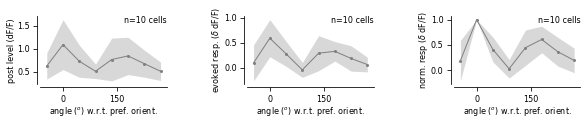

In [112]:
def population_tuning_fig(full_resp):

    Ncells = len(np.unique(full_resp['roi']))
    Neps = len(full_resp['roi'])/Ncells   
    angles = np.unique(full_resp['angle_from_pref'])

    fig, AX = ge.figure(axes=(3,1), figsize=(1.5,1.5))
    
    for ax in AX:
        ge.annotate(ax, 'n=%i cells' % full_resp['per_cell'].shape[0], (1,1), va='top', ha='right')
    
    ge.plot(angles, np.mean(full_resp['per_cell_post'], axis=0), 
            sy = np.std(full_resp['per_cell_post'], axis=0),
            color='grey', ms=2, m='o', ax=AX[0], no_set=True, lw=1)
    ge.set_plot(AX[0], xlabel='angle ($^{o}$) w.r.t. pref. orient.', ylabel='post level (dF/F)')
    
    ge.plot(angles, np.mean(full_resp['per_cell'], axis=0), 
            sy = np.std(full_resp['per_cell'], axis=0),
            color='grey', ms=2, m='o', ax=AX[1], no_set=True, lw=1)
    ge.set_plot(AX[1], xlabel='angle ($^{o}$) w.r.t. pref. orient.', ylabel='evoked resp. ($\delta$ dF/F)')
    
    ge.plot(angles, np.mean(full_resp['per_cell'].T/np.max(full_resp['per_cell'], axis=1).T, axis=1), 
            sy = np.std(full_resp['per_cell'].T/np.max(full_resp['per_cell'], axis=1).T, axis=1),
            color='grey', ms=2, m='o', ax=AX[2], no_set=True, lw=1)
    ge.set_plot(AX[2], xlabel='angle ($^{o}$) w.r.t. pref. orient.', 
                ylabel='norm. resp ($\delta$ dF/F)', yticks=[0,0.5,1])

    return fig

fig = population_tuning_fig(full_resp)
fig.savefig('/home/yann/Desktop/fig.svg')

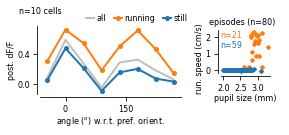

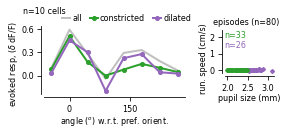

In [118]:
def behavior_mod_population_tuning_fig(full_resp,
                                       resp_key='evoked_level',
                                       pupil_threshold=2.5,
                                       running_speed_threshold = 0.1):

    Ncells = len(np.unique(full_resp['roi']))
    Neps = len(full_resp['roi'])/Ncells

    if 'speed_level' in full_resp:
        running_cond = (np.abs(full_resp['speed_level'])>=running_speed_threshold)
    else:
        running_cond = np.zeros(len(full_resp['roi']), dtype=bool) # False by default
        
    if 'pupil_level' in full_resp:
        dilated_cond = ~running_cond & (full_resp['pupil_level']>=pupil_threshold)
        constricted_cond = ~running_cond & (full_resp['pupil_level']<pupil_threshold)

    
    angles = np.unique(full_resp['angle_from_pref'])
    curves = {'running_mean': [], 'running_std':[],
              'still_mean': [], 'still_std':[],
              'dilated_mean': [], 'dilated_std':[],
              'constricted_mean': [], 'constricted_std':[]}

    for ia, angle in enumerate(angles):
        cond = full_resp['angle_from_pref']==angle
        # running
        curves['running_mean'].append(full_resp[resp_key][cond & running_cond].mean())
        curves['running_std'].append(full_resp[resp_key][cond & running_cond].std())
        # still
        curves['still_mean'].append(full_resp[resp_key][cond & ~running_cond].mean())
        curves['still_std'].append(full_resp[resp_key][cond & ~running_cond].std())
        # dilated pupil
        curves['dilated_mean'].append(full_resp[resp_key][cond & dilated_cond].mean())
        curves['dilated_std'].append(full_resp[resp_key][cond & dilated_cond].std())
        # constricted pupil
        curves['constricted_mean'].append(full_resp[resp_key][cond & constricted_cond].mean())
        curves['constricted_std'].append(full_resp[resp_key][cond & constricted_cond].std())
        

    # running vs still --- raw evoked response
    fig, ax = ge.figure(figsize=(1.5,1.5), right=6)
    ge.plot(angles, np.mean(full_resp['per_cell'], axis=0), label='all', color='grey', ax=ax, no_set=True, lw=2, alpha=.5)
    ge.plot(angles, curves['running_mean'], 
            color=ge.orange, ms=4, m='o', ax=ax, lw=2, label='running', no_set=True)
    ge.plot(angles, curves['still_mean'], 
            color=ge.blue, ms=4, m='o', ax=ax, lw=2, label='still', no_set=True)
    ge.legend(ax, ncol=3, loc=(.3,1.))
    
    inset = ge.inset(fig, [.8,.5,.16,.28])
    ge.scatter(full_resp['pupil_level'][running_cond],full_resp['speed_level'][running_cond],
               ax=inset, no_set=True, color=ge.orange)
    ge.scatter(full_resp['pupil_level'][~running_cond],full_resp['speed_level'][~running_cond],
               ax=inset, no_set=True, color=ge.blue)
    ge.annotate(ax, 'n=%i cells\n' % Ncells, (0.,1.), ha='center')
    ge.set_plot(ax, xlabel='angle ($^{o}$) w.r.t. pref. orient.', ylabel='post. dF/F')
    ge.set_plot(inset, xlabel='pupil size (mm)', ylabel='run. speed (cm/s)     ',
               title='episodes (n=%i)   ' % Neps)
    ge.annotate(inset, 'n=%i' % (np.sum(running_cond)/Ncells), (0.,1.), va='top', color=ge.orange)
    ge.annotate(inset, '\nn=%i' % (np.sum(~running_cond)/Ncells), (0.,1.), va='top', color=ge.blue)
 
    # constricted vs dilated --- raw evoked response
    fig2, ax = ge.figure(figsize=(1.5,1.5), right=6)
    inset2 = ge.inset(fig2, [.8,.5,.16,.28])
    ge.plot(angles, np.mean(full_resp['per_cell'], axis=0), label='all', color='grey', ax=ax, no_set=True, lw=2, alpha=.5)
    ge.plot(angles, curves['constricted_mean'], 
            color=ge.green, ms=4, m='o', ax=ax, lw=2, label='constricted', no_set=True)
    ge.plot(angles, curves['dilated_mean'], 
            color=ge.purple, ms=4, m='o', ax=ax, lw=2, label='dilated', no_set=True)
    ge.legend(ax, ncol=3, loc=(.1,1.))
    ge.scatter(full_resp['pupil_level'][dilated_cond],
               full_resp['speed_level'][dilated_cond],
               ax=inset2, no_set=True, color=ge.purple)
    ge.scatter(full_resp['pupil_level'][constricted_cond],
               full_resp['speed_level'][constricted_cond],
               ax=inset2, no_set=True, color=ge.green)
    ge.annotate(ax, 'n=%i cells\n' % len(np.unique(full_resp['roi'])), (0.,1.), ha='center')
    ge.set_plot(ax, xlabel='angle ($^{o}$) w.r.t. pref. orient.', ylabel='evoked resp, ($\delta$ dF/F)   ')
    ge.set_plot(inset2, xlabel='pupil size (mm)', ylabel='run. speed (cm/s)     ', ylim=inset.get_ylim(),
               title='episodes (n=%i)   ' % Neps)
    ge.annotate(inset2, 'n=%i' % (np.sum(constricted_cond)/Ncells), (0.,1.), va='top', color=ge.green)
    ge.annotate(inset2, '\nn=%i' % (np.sum(dilated_cond)/Ncells), (0.,1.), va='top', color=ge.purple)
    
    return fig, fig2

fig1, fig2 = behavior_mod_population_tuning_fig(full_resp,
                              running_speed_threshold = 0.1,
                              pupil_threshold=2.5)
fig1.savefig('/home/yann/Desktop/fig1.svg')
fig2.savefig('/home/yann/Desktop/fig2.svg')

0.5


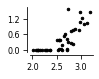

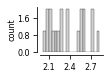

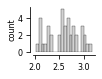

In [16]:
ge.scatter(Pupil_episodes.resp.mean(axis=1), Running_episodes.resp.mean(axis=1))
cond = (Running_episodes.resp.mean(axis=1)<0.25)
ge.hist(Pupil_episodes.resp.mean(axis=1)[cond])
ge.hist(Pupil_episodes.resp.mean(axis=1))
print(np.sum(cond)/len(cond))

## Datafile

We take a datafile that intermixes static and drifting gratings visual stimulation in a pseudo-randomized sequence

In [2]:
filename = os.path.join(os.path.expanduser('~'), 'DATA', 'data.nwb')
FullData= Data(filename)
print('the datafile has %i validated ROIs (over %i from the full suite2p output) ' % (np.sum(FullData.iscell),
                                                                                      len(FullData.iscell)))

the datafile has 293 validated ROIs (over 461 from the full suite2p output) 


# Orientation selectivity

Number of episodes over the whole recording: 40/120 (with protocol condition)
----
A value in x_new is below the interpolation range.
Problem with episode 0 between (1.02, 6.02)s
----
A value in x_new is above the interpolation range.
Problem with episode 119 between (1193.52, 1198.52)s
[ok] episodes ready !


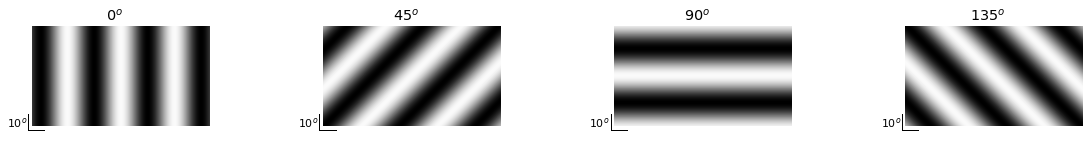

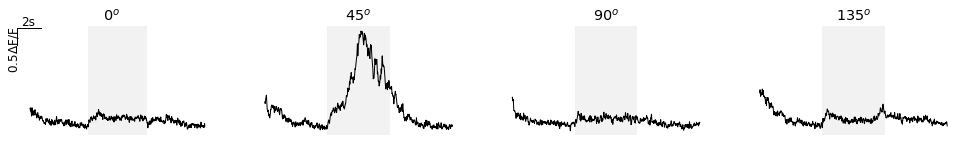

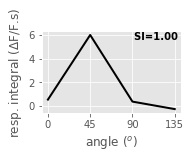

In [3]:
# Load data for FIRST PROTOCOL
data = CellResponse(FullData, protocol_id=0, quantity='CaImaging', subquantity='dF/F', roiIndex = 8)
# Show stimulation
fig, AX = data.show_stim('angle', figsize=(20,2))
# Compute and plot trial-average responses
fig, AX = plt.subplots(1, len(data.varied_parameters['angle']), figsize=(17,2.))
for i, angle in enumerate(data.varied_parameters['angle']):
    data.plot('angle',i, ax=AX[i], with_std=False)
    AX[i].set_title('%.0f$^o$' % angle)
# put all on the same axis range
YLIM = (np.min([ax.get_ylim()[0] for ax in AX]), np.max([ax.get_ylim()[1] for ax in AX]))
for ax in AX:
    ax.set_ylim(YLIM)
    data.add_stim(ax)
    ax.axis('off')
# add scale bar
add_bar(AX[0], Xbar=2, Ybar=0.5)
# Orientation selectivity plot based on the integral of the trial-averaged response
orientation_selectivity_plot(*data.compute_integral_responses('angle'))
# close the nwbfile
#data.io.close()

# Direction selectivity

Number of episodes over the whole recording: 80/120 (with protocol condition)
[ok] episodes ready !


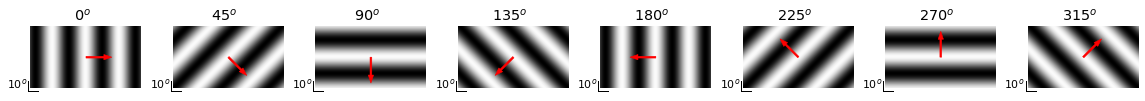

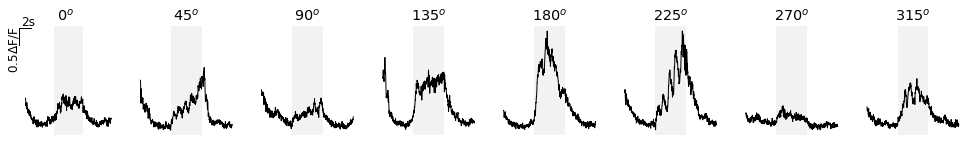

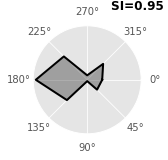

In [4]:
# Load data for FIRST PROTOCOL
data = CellResponse(FullData, protocol_id=1, quantity='CaImaging', subquantity='dF/F', roiIndex = 8)
# Show stimulation
fig, AX = data.show_stim('angle', figsize=(20,2), with_arrow=True)
# Compute and plot trial-average responses
fig, AX = plt.subplots(1, len(data.varied_parameters['angle']), figsize=(17,2.))
for i, angle in enumerate(data.varied_parameters['angle']):
    data.plot('angle',i, ax=AX[i], with_std=False)
    AX[i].set_title('%.0f$^o$' % angle)
# put all on the same axis range
YLIM = (np.min([ax.get_ylim()[0] for ax in AX]), np.max([ax.get_ylim()[1] for ax in AX]))
for ax in AX:
    ax.set_ylim(YLIM)
    data.add_stim(ax)
    ax.axis('off')
# add scale bar
add_bar(AX[0], Xbar=2, Ybar=0.5)
# Orientation selectivity plot based on the integral of the trial-averaged response
direction_selectivity_plot(*data.compute_integral_responses('angle'))
# close the nwbfile
#data.io.close()

Number of episodes over the whole recording: 80/120 (with protocol condition)
[ok] episodes ready !


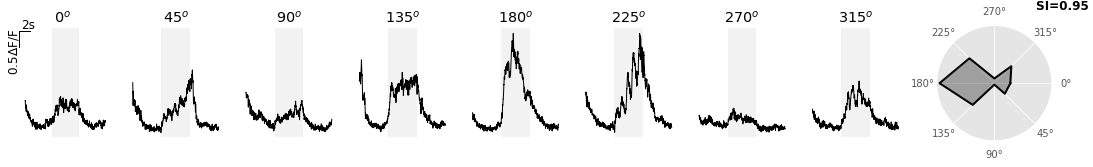

In [5]:
def direction_selectivity_analysis(FullData, roiIndex=0):
    data = CellResponse(FullData, protocol_id=1, quantity='CaImaging', subquantity='dF/F', roiIndex = roiIndex)
    fig, AX = plt.subplots(1, len(data.varied_parameters['angle']), figsize=(17,2.))
    plt.subplots_adjust(right=.85)
    for i, angle in enumerate(data.varied_parameters['angle']):
        data.plot('angle',i, ax=AX[i], with_std=False)
        AX[i].set_title('%.0f$^o$' % angle)
    # put all on the same axis range
    YLIM = (np.min([ax.get_ylim()[0] for ax in AX]), np.max([ax.get_ylim()[1] for ax in AX]))
    for ax in AX:
        ax.set_ylim(YLIM)
        data.add_stim(ax)
        ax.axis('off')
    # add scale bar
    add_bar(AX[0], Xbar=2, Ybar=0.5)
    # Orientation selectivity plot based on the integral of the trial-averaged response
    ax = plt.axes([0.85,0.1,0.15,0.8], projection='polar')
    direction_selectivity_plot(*data.compute_integral_responses('angle'), ax=ax)
    return fig
fig = direction_selectivity_analysis(FullData, roiIndex=8)

Number of episodes over the whole recording: 40/120 (with protocol condition)
Problem with episode 0 between (1.02, 6.02)s
Problem with episode 119 between (1193.52, 1198.52)s
[ok] episodes ready !


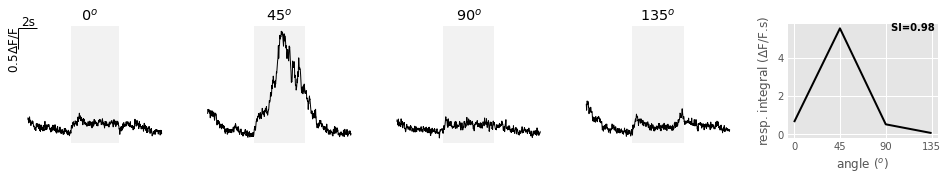

In [103]:
def orientation_selectivity_analysis(FullData, roiIndex=0):
    data = CellResponse(FullData, protocol_id=0, quantity='CaImaging', subquantity='dF/F', roiIndex = 8)
    fig, AX = plt.subplots(1, len(data.varied_parameters['angle']), figsize=(14,2.))
    plt.subplots_adjust(right=.8)
    for i, angle in enumerate(data.varied_parameters['angle']):
        data.plot('angle',i, ax=AX[i], with_std=False)
        AX[i].set_title('%.0f$^o$' % angle)
    YLIM = (np.min([ax.get_ylim()[0] for ax in AX]), np.max([ax.get_ylim()[1] for ax in AX]))
    for ax in AX:
        ax.set_ylim(YLIM)
        data.add_stim(ax)
        ax.axis('off')
    add_bar(AX[0], Xbar=2, Ybar=0.5)
    ax = plt.axes([0.85,0.1,0.15,0.8])
    orientation_selectivity_plot(*data.compute_integral_responses('angle'), ax=ax)
orientation_selectivity_analysis(FullData, roiIndex=8)

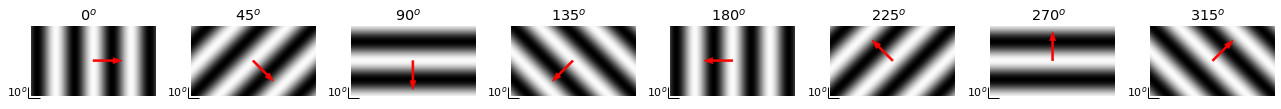

In [105]:
fig, AX = data.show_stim('angle', figsize=(20,2), with_arrow=True)
fig.savefig('/home/yann/Desktop/data2/stim.svg')